# Train Model to play pong

In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading and inspecting training data

In [42]:
dataset = np.load(file="traindata_v2.npy", encoding='bytes')

In [43]:
from collections import Counter
labels_counter = Counter(dataset[:,6].tolist())
print(labels_counter)

print("Prediction must be higher than: {}".format(labels_counter[0.0]/dataset.shape[0]))

Counter({0.0: 14764, 1.0: 2708, 2.0: 2528})
Prediction must be higher than: 0.7382


## Create size invariant features
We will get the approximate width and height of the game window and divide vertical and horizontal features by these values so we get size invariant features so the model can perform nearly the same in any size.

In [44]:
def set_size_invariant_features(dataset):
    #Get max and min feature values of the entire dataset
    min_values = np.amin(dataset, axis=0)
    max_values = np.amax(dataset, axis=0)
    
    #We will set the width the difference between the bars horizontal positions max and min
    gwindow_width = max_values[4] - min_values[2]
    #We will set the height as the difference between the max and mins positions the ball has deslocated
    gwindow_height = max_values[1] - min_values[1]
    
    #Create vector to transform features to position invariant
    #We will divide horizontal features by the width and vertical features by the height
    pos_invariant_vector = np.array([
        gwindow_width, gwindow_height, #Ball position
        gwindow_width, gwindow_height, #Bar1 position
        gwindow_width, gwindow_height, #Bar2 position
        1 #datapoint label, stays the same
    ])
    
    return dataset/pos_invariant_vector

In [45]:
dataset = set_size_invariant_features(dataset)

## Set up ball speed as a feature

In [46]:
def set_ball_speed(dataset):
    #Since we don't know the previous position of the first sample, we will have one less datapoint
    #Velocity(T) = Position(T) - Position(T-1)
    speed_datapoints = dataset[1:, :2] - dataset[0:-1, :2]
    #Insert new datapoints after the ball position features
    new_dataset = np.concatenate((dataset[1:, :2], speed_datapoints, dataset[1:, 2:]), axis=1)
    return new_dataset   

In [47]:
dataset = set_ball_speed(dataset)

## Creating model

In [48]:
tf.reset_default_graph()

n_features = 8

x_mean = tf.Variable(initial_value=[0]*n_features, trainable=False, dtype=tf.float32)
x_std = tf.Variable(initial_value=[1]*n_features, trainable=False, dtype=tf.float32)

x = tf.placeholder(dtype=tf.float32, shape=[None, n_features])

x_norm = (x-x_mean)/x_std
    
y = tf.placeholder(dtype=tf.int32, shape=[None])
y_onehot = tf.one_hot(y, depth=3)
    
h1 = tf.layers.dense(x, 20, activation=tf.nn.relu)
h2 = tf.layers.dense(h1, 20, activation=tf.nn.relu)
#h3 = tf.layers.dense(h2, 10, activation=tf.nn.relu)
    
logits = tf.layers.dense(h2, 3, activation=None)

sc = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_onehot)

cost = tf.reduce_mean(sc)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

#Optimizer
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

In [49]:
def balance_data_labels():
    extra_data_inputs = list()
    extra_data_labels = list()

    for d_input, d_label in zip(train_data_inputs, train_data_labels):
        if d_label[1] == 1 or d_label[2] == 1:
            for _ in range(5):
                extra_data_inputs.append(d_input.copy())
                extra_data_labels.append(d_label.copy())

    extra_data_inputs = np.array(extra_data_inputs)
    extra_data_labels = np.array(extra_data_labels)

    print(extra_data_inputs.shape)
    print(extra_data_labels.shape)

    enhanced_train_data_inputs = np.concatenate((train_data_inputs, extra_data_inputs), axis=0)
    enhanced_train_data_labels = np.concatenate((train_data_labels, extra_data_labels), axis=0)

    print(enhanced_train_data_inputs.shape)
    print(enhanced_train_data_labels.shape)

## Normalize data

In [50]:
def normalize_data():
    data_mean = np.mean(enhanced_train_data_inputs, axis=0)
    data_std = np.std(enhanced_train_data_inputs, axis=0)

    norm_enhanced_train_data_inputs = (enhanced_train_data_inputs - data_mean) / data_std

## Get norm factors

In [51]:
data_mean = np.mean(dataset, axis=0)
data_std = np.std(dataset, axis=0)

## Split dataset into training validation and test set

In [52]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataset, test_size=0.4, random_state=None)
valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=None)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(11999, 9)
(4000, 9)
(4000, 9)


In [53]:
print(train_data[:1, :-1])
print(train_data[:1, -1])

[[ 0.12612185  0.0712743  -0.01959174  0.00431965  0.08571388  0.27861771
   1.08004808  0.16225937]]
[ 0.]


## Run model

Epoch: 0 Cost: 1.0058982372283936
Accuracy: 0.5285000205039978

Epoch: 500 Cost: 0.6440725922584534
Accuracy: 0.7425000071525574

Epoch: 1000 Cost: 0.584337055683136
Accuracy: 0.7677500247955322

Epoch: 1500 Cost: 0.5386120080947876
Accuracy: 0.7889999747276306

Epoch: 2000 Cost: 0.493974506855011
Accuracy: 0.8044999837875366

Epoch: 2500 Cost: 0.46625053882598877
Accuracy: 0.809499979019165

Epoch: 3000 Cost: 0.44995737075805664
Accuracy: 0.8117499947547913

Epoch: 3500 Cost: 0.43750202655792236
Accuracy: 0.8152499794960022

Epoch: 4000 Cost: 0.43082860112190247
Accuracy: 0.8184999823570251

Epoch: 4500 Cost: 0.426719605922699
Accuracy: 0.8195000290870667

Epoch: 5000 Cost: 0.42346230149269104
Accuracy: 0.8205000162124634

Epoch: 5500 Cost: 0.42081648111343384
Accuracy: 0.8199999928474426

Epoch: 6000 Cost: 0.41890397667884827
Accuracy: 0.8195000290870667

Epoch: 6500 Cost: 0.4170292317867279
Accuracy: 0.8182500004768372

Epoch: 7000 Cost: 0.41517555713653564
Accuracy: 0.8180000185966

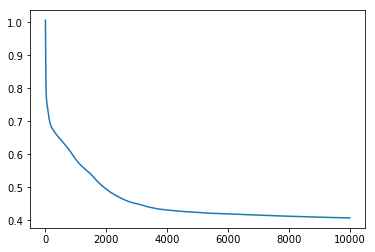

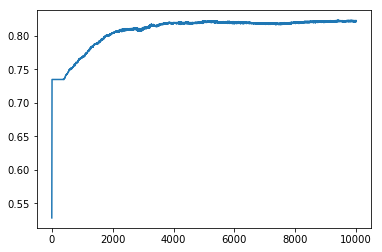

Final accuracy: 0.8027499914169312


In [54]:
from random import shuffle
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib

epochs = 10000

cost_list = []
acc_list = []

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    #Assign norm factors values
    #sess.run(tf.assign(x_mean, data_mean[:-1]))
    #sess.run(tf.assign(x_std, data_std[:-1]))

    for e in range(epochs):
        
        #Run optimizer and compute cost
        x_train = train_data[:, :-1]
        y_train = train_data[:, -1]
                
        cost_value, _ = sess.run([cost, optimizer], feed_dict={
            x: x_train,
            y: y_train
        })

        if e % 500 == 0:
            print("Epoch: {} Cost: {}".format(e, cost_value))

        cost_list.append(cost_value)

        
        
        #Run accuracy and compute its value
        x_valid = valid_data[:, :-1]
        y_valid = valid_data[:, -1]
        
        acc_value = sess.run(accuracy, feed_dict={
            x: x_valid,
            y: y_valid
        })
                
        acc_list.append(acc_value)

        if e % 500 == 0:
            print("Accuracy: {}".format(acc_value))
            print("")
            
            
     
    #Calculate final accuracy
    x_test = test_data[:, :-1]
    y_test = test_data[:, -1]
    
    final_acc, predictions = sess.run([accuracy, logits], feed_dict={
            x: x_test,
            y: y_test
        })
    
    #print(predictions)

             
    plt.plot(cost_list)
    plt.show()
    plt.plot(acc_list)
    plt.show()
    print("Final accuracy: {}".format(final_acc))
            
    saver = tf.train.Saver()
    save_path = saver.save(sess, "./model/model_v21.ckpt")

In [55]:
print(Counter(np.argmax(predictions, axis=1).tolist()))
print(Counter(y_test))

Counter({0: 3161, 1: 420, 2: 419})
Counter({0.0: 2882, 1.0: 575, 2.0: 543})
